In [ ]:
# 1. Thêm các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.applications import VGG16
from keras.backend import clear_session
from keras.optimizers import SGD
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import random
import cv2
import os
import zipfile

In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1MDYPQIllP0pDv79tTOn5Uc0exDO4pbQA&export=download

Downloading...
From: https://drive.google.com/u/0/uc?id=1MDYPQIllP0pDv79tTOn5Uc0exDO4pbQA
To: /content/dog_data.zip
100% 37.8M/37.8M [00:00<00:00, 140MB/s]


In [ ]:
local_zip = "/content/dog_data.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("")
zip_ref.close()

In [ ]:
# 2. Đọc đữ liệu csv
data = pd.read_csv("/content/dog_data/train.csv", sep=";")
data = data.sample(frac=1).reset_index(drop=True)
data

,fn,class
0,shih-tzu/n02086240_4346.jpg,shih-tzu
1,border-collie/n02106166_1663.jpg,border-collie
2,shih-tzu/n02086240_7100.jpg,shih-tzu
3,chihuahua/n02085620_3033.jpg,chihuahua
4,shih-tzu/n02086240_6898.jpg,shih-tzu
...,...,...
962,pekinese/n02086079_422.jpg,pekinese
963,doberman/n02107142_11493.jpg,doberman
964,pekinese/n02086079_6180.jpg,pekinese
965,doberman/n02107142_10009.jpg,doberman


In [ ]:
# 3. Tạo X_train, X_test, y_val, y_val

# Lấy đường dẫn ảnh và nhãn từ cột "fn" và "class"
image_paths = data["fn"].values
labels = data["class"].values

# X_data chứa dữ liệu từ train
X_data = []

for path in image_paths:
    img = cv2.imread("/content/dog_data/train/" + path)  # Đọc ảnh màu
    img = cv2.resize(img, (224, 224))  # Resize ảnh về kích thước 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    X_data.append(img)

X_data = np.array(X_data)

# Chia dữ liệu thành tập huấn luyện và tập validation theo tỉ lệ 8:2
X_train = X_data[:770]
y_train = labels[:770]

X_val = X_data[770:]
y_val = labels[770:]

# In kích thước của dữ liệu từ file CSV
print(X_train.shape)
print(X_val.shape)

(770, 224, 224, 3)
(197, 224, 224, 3)


In [ ]:
# Tạo X_test
test_folder_path = "/content/dog_data/test/"
X_test = []

for filename in os.listdir(test_folder_path):
    path = os.path.join(test_folder_path, filename)

    # Kiểm tra xem tệp có phải là ảnh không
    if os.path.isfile(path) and path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img = cv2.imread(path)  # Đọc ảnh màu

        # Kiểm tra xem ảnh có được đọc thành công không
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize ảnh về kích thước 224x224
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Chuyển đổi hệ màu về đúng
            X_test.append(img)
        else:
            print(f"Could not read image: {path}")
    else:
        print(f"Unsupported file format: {path}")

# Chuyển danh sách ảnh thành mảng numpy
X_test = np.array(X_test)

In [ ]:
# 4. Chuẩn hóa train, valid, test
# Đảm bảo số kênh là 3 vì ảnh màu (RGB)
X_train = X_train.reshape(X_train.shape[0], 224, 224, 3)
X_val = X_val.reshape(X_val.shape[0], 224, 224, 3)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 3)

# Chuẩn hóa giá trị pixel về khoảng [0, 1]
X_train = X_train/255.
X_val = X_val/255.
X_test = X_test/255.

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(770, 224, 224, 3)
(197, 224, 224, 3)
(82, 224, 224, 3)


In [ ]:
# 5. Mã hóa nhãn
# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
print('Dữ liệu y_train trước mã hóa: ', y_train[:10])
# Mã hóa nhãn của y_train thành dạng số
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)

# Hiển thị một số giá trị sau khi mã hóa
y_train = to_categorical(y_train, num_classes=6)
y_val = to_categorical(y_val, num_classes=6)
print('Dữ liệu y_train sau khi mã hóa: ', y_train[:10])
print('Dữ liệu y_val sau khi mã hóa: ', y_val[:10])

Dữ liệu y_train trước mã hóa:  ['shih-tzu' 'border-collie' 'shih-tzu' 'chihuahua' 'shih-tzu' 'pekinese'
 'border-collie' 'chihuahua' 'border-collie' 'rottweiler']
Dữ liệu y_train sau khi mã hóa:  [[0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]
Dữ liệu y_val sau khi mã hóa:  [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [ ]:
# 6. Khởi tạo mô hình

clear_session()

model = VGG16(include_top=False, input_shape=(224,224)+(3,))
for layer in model.layers[:-4]:  # Đóng băng tất cả trừ 4 lớp cuối cùng
    layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(512, activation='relu', kernel_initializer='he_uniform')(flat1)
output = Dense(6, activation='softmax')(class1)  # Sử dụng 'softmax' cho bài toán đa lớp
model = Model(inputs=model.inputs, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate = 0.001, momentum = 0.9)  ##các siêu tham số
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
model.optimizer.get_config()

{'name': 'SGD',
 'weight_decay': None,
 'clipnorm': None,
 'global_clipnorm': None,
 'clipvalue': None,
 'use_ema': False,
 'ema_momentum': 0.99,
 'ema_overwrite_frequency': None,
 'jit_compile': True,
 'is_legacy_optimizer': False,
 'learning_rate': 0.001,
 'momentum': 0.9,
 'nesterov': False}

In [ ]:
# 7. Thực hiện train model với data
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
25/25 [==============================] - 7s 218ms/step - loss: 1.8179 - acc: 0.2792 - val_loss: 1.9763 - val_acc: 0.2589
Epoch 2/10
25/25 [==============================] - 4s 174ms/step - loss: 1.2089 - acc: 0.5312 - val_loss: 1.0582 - val_acc: 0.6193
Epoch 3/10
25/25 [==============================] - 4s 172ms/step - loss: 0.5721 - acc: 0.7987 - val_loss: 1.2710 - val_acc: 0.4924
Epoch 4/10
25/25 [==============================] - 4s 172ms/step - loss: 0.6358 - acc: 0.7545 - val_loss: 0.8171 - val_acc: 0.6599
Epoch 5/10
25/25 [==============================] - 5s 196ms/step - loss: 0.2399 - acc: 0.9247 - val_loss: 0.6780 - val_acc: 0.7310
Epoch 6/10
25/25 [==============================] - 4s 174ms/step - loss: 0.1084 - acc: 0.9818 - val_loss: 0.6563 - val_acc: 0.7614
Epoch 7/10
25/25 [==============================] - 5s 194ms/step - loss: 0.0446 - acc: 0.9961 - val_loss: 0.6386 - val_acc: 0.7614
Epoch 8/10
25/25 [==============================] - 5s 199ms/step - loss: 0.

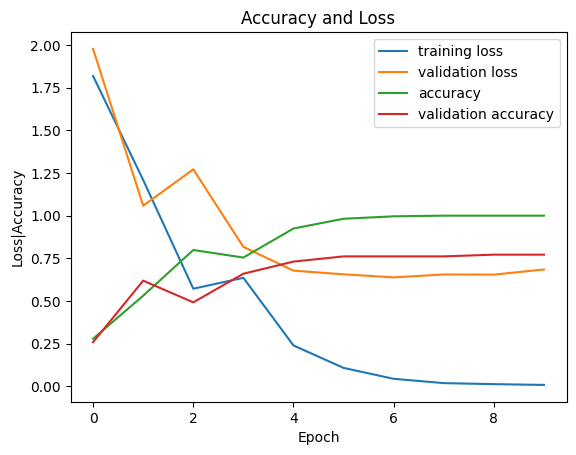

In [ ]:
# 8. Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

1/1 [==============================] - 0s 19ms/step
Giống chó dự đoán:  rottweiler


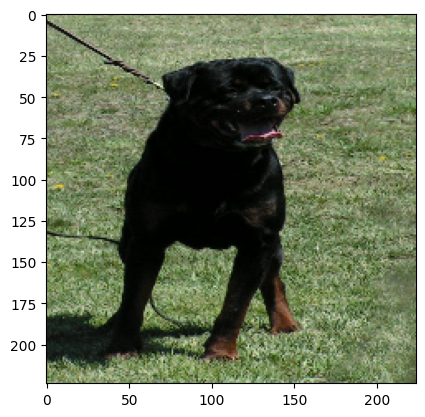

In [ ]:
#9. In một ảnh ngẫu nhiên từ tập test

class_mapping = {0: 'border-collie', 1: 'chihuahua', 2: 'doberman', 3:'pekinese', 4: 'rottweiler', 5: 'shih-tzu'}

# Chọn ngẫu nhiên một ảnh từ X_test
random_index = random.randint(0, len(X_test) - 1)
random_image = X_test[random_index]* 255

# Kiểm tra định dạng màu của ảnh
if random_image.max() > 1:
    random_image = random_image.astype('float32') / 255.0  # Chuẩn hóa giá trị pixel nếu định dạng màu là [0, 255]

# Hiển thị ảnh
plt.imshow(random_image)

# Định dạng ảnh để phù hợp với mô hình
img = image.img_to_array(random_image)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))

# Dự đoán
y_predict = model.predict(img)
predicted_class = np.argmax(y_predict)

# Hiển thị giống chó dự đoán
predicted_breed = class_mapping.get(predicted_class)
print('Giống chó dự đoán: ', predicted_breed)



In [ ]:
#10. Lưu model
model.save('/content/model.h5')

In [ ]:
from google.colab import files
from IPython.display import display, HTML, Image
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt

Saving cho-border-collie-3.png to cho-border-collie-3.png


{'cho-border-collie-3.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xdd\x00\x00\x01\xf4\x08\x03\x00\x00\x00O@\x07\xa2\x00\x00\x00\x04gAMA\x00\x00\xb1\x8f\x0b\xfca\x05\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x00]PLTE\xff\xff\xff620\xbc\xb5\xa3zwo\x18\x18\x18\x1e\x1c\x1c0,*\n\n\x0c\'$#\x12\x12\x12<86B@>\xd2\xd0\xc7WOK\xac\xa8\x9c\x98\x92\x85\xa3\x9d\x92\x8b\x86|le_LHD\xe1\xdf\xd9\xdb\xd7\xcf\xf7\xf7\xf7\xe9\xe7\xe3\xef\xef\xef`ZV\xcd\xc7\xbb\xc3\xc1\xb5\xb5\xb7\xb3\xe7\xad\xb7\xcb\x8d\x97\xd5\x0b"\xa4\x00\x00 \x00IDATx\xda\xec[\rs\xa4\xb6\x12<\x95\x84\xf8\x10\xc2\x80\xf8\x10\x86\xff\xff;\xdf\xf4\x0c\xb0\xeb$\xe5K\xbc\xbe\xe4\xd5\xd5\xb4\xe3[{m\xb3)Z\xdd\xd33\xd2\xfe\xf8\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1P(\x14\n\x85B\xa1\xf8\x1e,z\x0b~OV\x17%\xf7\xb7U+\x1e\xb2\x92\xfb;\xd9\xe8u\x81e\xc1WSV\xf5\xfe^\xcbcaO\x86h\x97ve\x96\xe9cQ\x8e\xff_\xd8y\xe5\xcf\x17Qm^\xe9\x8b}\xc2

Đã tải lên file: cho-border-collie-3.png


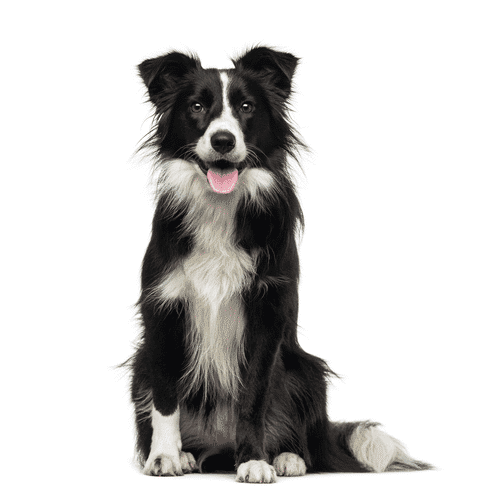

In [ ]:
# Tạo nút tải lên
upload_button = files.upload()

# Hiển thị nút trên giao diện
display(upload_button)

# Sau khi bạn đã tải lên file, bạn có thể lấy đường dẫn của file bằng cách sử dụng list(upload_button.keys())[0]

# Load ảnh từ file đã tải lên
if upload_button:
    img_path = list(upload_button.keys())[0]
    print(f'Đã tải lên file: {img_path}')
    img = cv2.imread(img_path)
    display(Image(filename=img_path))
else:
    print('Không có file nào được tải lên.')

In [ ]:
model = load_model("/content/drive/MyDrive/BTL/DOG BREED CLASSIFICATION/model.h5")

# Load ảnh và tiền xử lý
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Chuẩn hóa giá trị pixel về khoảng [0, 1]

1/1 [==============================] - 1s 704ms/step
Predicted class: border-collie


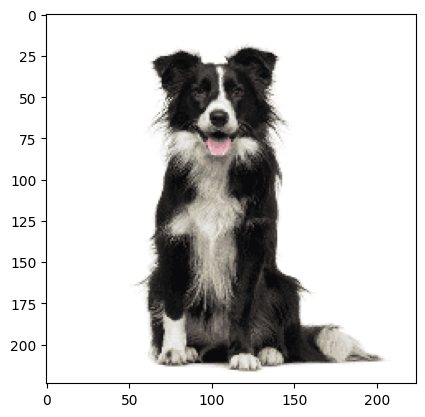

In [ ]:
class_mapping = {0: 'border-collie', 1: 'chihuahua', 2: 'doberman', 3:'pekinese', 4: 'rottweiler', 5: 'shih-tzu'}
# Dự đoán
predictions = model.predict(img_array)


# Lấy chỉ số có xác suất cao nhất
predicted_class = np.argmax(predictions[0])
predicted_breed = class_mapping.get(predicted_class)

plt.imshow(img)
print("Predicted class:", predicted_breed)